<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Generalized Linear Models

_Authors: Tim Book, Justin Pounders (ATL), Matt Brems_

### Learning Objectives
*After this lesson, students will be able to:*

1. Describe generalized linear models.
2. Fit Poisson and Gamma regression models in `statsmodels`.
3. Interpret coefficients from Poisson and Gamma regression models.
4. Describe iteratively reweighted least squares.

### Recall: The Anatomy of a GLM
GLMs are made up of three components:
* **Systematic component** (or **linear component**) - The choice of _x_-variables in your model.
* **Random component** - Distributional assumption of $y_i$.
* **Link function** - The function that connects systematic and random components. Must input the range of possible values of $\mu_i$ and output $\mathbb{R}$.

While there are many kinds of GLMs out there, today we'll focus on two new commonly used ones:
* **Poisson regression**
* **Gamma regression**

## The `statsmodels` API

We will use the `statsmodels` API to explore GLMs in Python.  (`sklearn` does not have a robust implementation for GLMs.)  Documentation and examples for `statsmodels` can be found [here](http://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM).

Fitting GLMs in `statsmodels` will be as easy as using the `sm.GLM()` class and setting the three components.

## Poisson Regression

**When do we use it?** When we want to model something on the $\{0,1,2,\ldots\}$ range... like number of cars on through a toll road, number of objects sold or number of awards earned!

<img src="./images/poisson_model.png" alt="poisson_model" width="400"/>

#### Data
We'll rely on UCLA's IDRE module.  This one can be found [here](https://stats.idre.ucla.edu/r/dae/poisson-regression/).

#### Data Description
_The number of awards earned by students at one high school. Predictors of the number of awards earned include the type of program in which the student was enrolled (e.g., vocational, general or academic) and the score on their final exam in math._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [2]:
# Read in data.
award = pd.read_csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")

# Check first five rows.
award.head()

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40


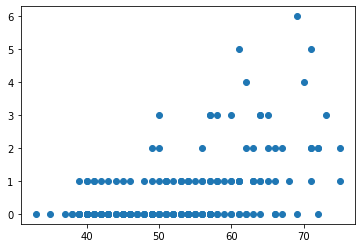

In [3]:
# Plot a scatterplot of math score vs. number of awards.
plt.scatter(award['math'], award['num_awards']);

<AxesSubplot:xlabel='prog', ylabel='num_awards'>

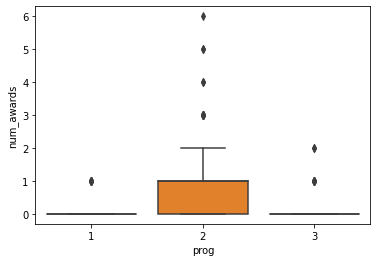

In [4]:
# Plot distribution of awards by program.
sns.boxplot(data=award, x='prog', y='num_awards')

<details><summary>What might we infer from this plot?</summary>

- `prog` is definitely not linearly related to the number of awards one receives.
- `prog` looks like a categorical variable.
- I am aware of this. I'm going to suspend that knowledge for the sake of example.
</details>

In [5]:
# One hot encoding the prog column
award_dummy = pd.get_dummies(columns=['prog'], data=award, drop_first=True)
award_dummy.head()

,id,num_awards,math,prog_2,prog_3
0,45,0,41,0,1
1,108,0,41,0,0
2,15,0,44,0,1
3,67,0,42,0,1
4,153,0,40,0,1


In [6]:
# Set up X.
poi_vars = ['prog_2', 'prog_3', 'math']

# Recall in statsmodels we need to add the constant (unlike sklearn which does it automatically)
X = sm.add_constant(award_dummy[poi_vars])

# Set up y.
y = award['num_awards']

What are the three components of a poisson regression GLM?
1. Systematic component - We already picked this
2. Random component - Poisson distribution
3. Link function - log

In [8]:
# Fit model.
glm_poi = sm.GLM(
    y, X,
    family=sm.families.Poisson(link = sm.families.links.log())
).fit()

# In statsmodels, y is the first argument.
# In statsmodels, X is the second argument.

In [9]:
# Generate summary of model.
glm_poi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             num_awards   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -182.75
Date:                Tue, 15 Feb 2022   Deviance:                       189.45
Time:                        15:26:31   Pearson chi2:                     212.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2471      0.658     -7.969      0.000      -6.538      -3.957
prog_2         1.0839      0.358      3.025      0.002       0.382       1.786
prog_3         0.3698      0.441      0.838      0.402      -0.495       1.234
math           0.0702      0.011      6.619      0.000       0.049       0.091
==============================================================================
"""

---
### To the slides!
---

#### Interpreting Poisson Coefficients

Because of the log link function, we interpret a one-unit increase in $X_i$ as follows:

"As $X_i$ increases by 1, I expect $Y$ to increase by a factor of $e^{\beta_1}$."

In [10]:
# Beta of "Math"
np.exp(0.0702)

1.072722704342061

**Example**: All else held equal, for a one-unit increase in `math`, I expect to win $e^{0.0702} \approx 1.07$ times as many awards.

In [11]:
# Beta of "prog_2"
np.exp(1.0839)

2.9561862247436466

<details><summary>How would you interpret `prog_2`?</summary>
    If you are in Program 2, I expect to win $e^{1.0839} \approx 3$ times as many awards as if you were in Program 1, holding all else constant.
</details>

---
### To the slides!
---

## Gamma Regression

**When do we use it?** When we want to model something on the $[0,\infty)$ range... like time until some event occurs!

### The Data
The data used from this example come from a 1945 study about and is inspired by [Peter Craigmile's use](http://www.craigmile.com/peter/teaching/7430/notes/7_gamma_influence.pdf) of this example.

**Data Description:** _“Hurn, et al. (1945) published data on the clotting time of blood, giving clotting time in seconds for normal plasma diluted to nine different percentage concentrations with prothrombin-free plasma; clotting was induced by two lots of thromboplastin.” [McCullagh and Nelder](http://www.utstat.toronto.edu/~brunner/oldclass/2201s11/readings/glmbook.pdf)_

In [12]:
# Read data in.
clot = pd.read_csv("../datasets/clotting.csv", index_col="index")

In [13]:
# Check the first five rows.
clot.head()

,plasma_pct,clot_time,lot
index,,,
1,5,118,1
2,10,58,1
3,15,42,1
4,20,35,1
5,30,27,1


<AxesSubplot:xlabel='lot', ylabel='clot_time'>

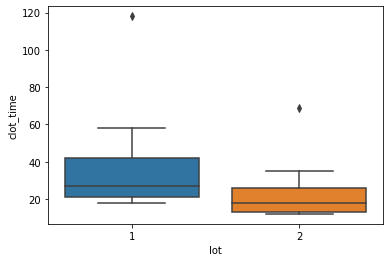

In [14]:
# Generate a boxplot of clot_time group by lot.
sns.boxplot(data=clot, x='lot', y='clot_time')

<AxesSubplot:xlabel='plasma_pct', ylabel='clot_time'>

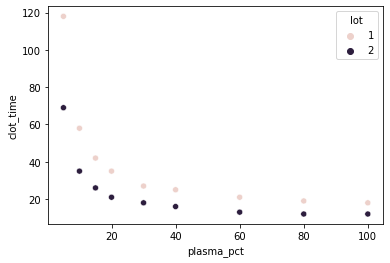

In [15]:
# Plot plasma_pct against clot_time.
sns.scatterplot(data=clot, x='plasma_pct', y='clot_time', hue='lot')

In [16]:
# Take the base 10 log of plasma_pct.
clot['plasma_pct_log10'] = np.log10(clot['plasma_pct'])

<AxesSubplot:xlabel='plasma_pct_log10', ylabel='clot_time'>

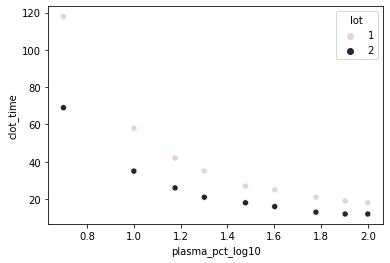

In [17]:
# Plot our new variable against clot_time.
sns.scatterplot(data=clot, x='plasma_pct_log10', y='clot_time', hue='lot')

In [18]:
# Set up X.
# X = sm.add_constant(clot[['plasma_pct_log10', 'lot']])
X = sm.add_constant(clot[['plasma_pct', 'lot']])

# Set up y.
y = clot['clot_time']

In [19]:
# Fit model.
results = sm.GLM(
    y, X,
    family=sm.families.Gamma(link = sm.families.links.log())
#     family = sm.families.Gamma(link = sm.families.links.inverse_power)
).fit()

# In statsmodels, y is the first argument.
# In statsmodels, X is the second argument.

In [20]:
# Generate summary of model.
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              clot_time   No. Observations:                   18
Model:                            GLM   Df Residuals:                       15
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                         0.16619
Method:                          IRLS   Log-Likelihood:                -65.573
Date:                Tue, 15 Feb 2022   Deviance:                       2.0364
Time:                        15:27:04   Pearson chi2:                     2.49
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6597      0.328     14.222      0.000       4.017       5.302
plasma_pct    -0.0156      0.003     -5.084      0.000      -0.022      -0.010
lot           -0.4753      0.192     -2.473      0.013      -0.852      -0.099
==============================================================================
"""

#### Interpreting Gamma Coefficients

Because of the log link function (again!), we interpret a one-unit increase in $X_i$ as follows:

"As $X_i$ increases by 1, I expect $Y$ to increase by a factor of $e^{\beta_1}$."

In [20]:
# Coeff of plasma_pct.
np.exp(-0.0156)

0.9845210497239912

<details><summary>How would you interpret plasma_pct?</summary>

For a one-unit increase in `plasma_pct`, I expect the blood will take $e^{-0.0156} \approx 98\%$ as much time to clot, holding `lot` constant.
    
Another way to think about this is, for a one-unit increase in `plasma_pct`, I expect the blood will clot about $2\%$ faster, holding `lot` constant.
</details>

---
## Iteratively Reweighted Least Squares

When fitting an OLS regression model, we can find our best values for $\beta$ by solving $\hat{\pmb\beta} = (X^TX)^{-1}X^Ty$.

GLMs are typically not "directly solvable." There is [no closed-form solution](http://mathworld.wolfram.com/Closed-FormSolution.html) for generalized linear models!
- This includes logistic regression!

#### How does the algorithm work?
An algorithm called "iteratively reweighted least squares" [has been shown](http://www.utstat.toronto.edu/~brunner/oldclass/2201s11/readings/glmbook.pdf) is "easy" to implement in a computer.
- A solution is initially guessed, then iteratively refined until we converge on an answer.
- IRLS is a special case of a **gradient descent algorithm**. We'll learn about gradient descent tomorrow.

$$
\begin{eqnarray*}
\hat{\pmb\beta}_{[1]} &=& (X^TW_1X)^{-1}X^TW_1y \\
\Rightarrow \hat{\pmb\beta}_{[2]} &=& (X^TW_2X)^{-1}X^TW_2y \\
\Rightarrow \hat{\pmb\beta}_{[3]} &=& (X^TW_3X)^{-1}X^TW_3y \\
\Rightarrow \hat{\pmb\beta}_{[4]} &=& (X^TW_4X)^{-1}X^TW_4y \\
\Rightarrow \hat{\pmb\beta}_{[5]} &=& (X^TW_5X)^{-1}X^TW_5y \\
&\vdots& \\
\Rightarrow \hat{\pmb\beta}_{[99]} &=& (X^TW_{99}X)^{-1}X^TW_{99}y \\
\Rightarrow \hat{\pmb\beta}_{[100]} &=& (X^TW_{100}X)^{-1}X^TW_{100}y \\
\end{eqnarray*}
$$

- At each step ("iteration"), these weights will change. ("reweighted")

The default maximum number of iterations for GLMs in `statsmodels` is 100. 
- If `No. Iterations` is less than 100, that means the algorithm probably converged.
- If `No. Iterations` is 100, that means the algorithm probably didn't converge and that the $\mathbf{\hat{\beta}}$ are still changing. Therefore, **your output is unreliable - DO NOT USE IT**. It could also give some information on the "flatness" of your error function. Even more than 20 iterations is sketchy.

There are potential pitfalls to this algorithm (some of which we'll cover later). However, what you should know:
- If you get a `ConvergenceWarning` or any indication that your number of iterations is large, that means that your model did not fit properly and that you should not rely on the results!

---

In [21]:
# Did our results converge?
results.converged

True

## Summary
Today, we:
* Learned how to generalize two models we already knew (linear and logistic regression) into a borader category of models (GLMs)
* Refamiliarized ourselves with the `statsmodels` API
* Learned the components of GLMs, and how to customize them with `statsmodels`:
    - Systematic/linear component, ie, our choice of x-variables
    - Link function - a function we choose to "bend" our response to our y-variable
    - Random component - The distribution that represents the data-generation process for our y-variable
* Two new linear models:
    - **Poisson regression** - For when your y-variable is Poisson distributed. Most commonly used for _count data_.
        - e.g. Predicting how many children a couple will have based on age and income
        - e.g. Predicting how many semiconductor chips will pass the final tests based on the critical measurements during its processing
    - **Gamma regression** - For when your y-variable is Gamma distributed. Most commonly used for _waiting-time data_.
        - e.g. Predicting how long your phone's battery will last based on screentime use
        - e.g. Predicting how long before some manufacturing equipment will fail based on all the sensore data

![](images/glm-sheet.png)

---

## Picking other GLMs (BONUS)

Chosing the right kind of generalized linear model (GLM) from all possibilities really boils down to picking the "error."

The "error" model is really telling you how you expect observations to be distributed.  It is a probability distribution.

> 1. In traditional linear regression, the error term is a normal distribution.  This means that you expect actual observations to be normally distributed around your line.

> 2. In logistic regression, the error term is a Bernoulli distribution.  This means that you expect actual observations to be above (1) or below (0) the logit curve with a certain probability.

Choosing the distribution function often points to a link function you should use: [here is a table](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function).

Examples:

1. If $Y$ is a non-negative integer:
   - Poisson regression if mean $\approx$ variance
   - Negative Binomial regression if variance $\gg$ mean (overdisperse)
   - For example,
     - Units sold
     - Customers through the door
     - Patients to the ER
     - Number of cars racing the red light
     - Semiconductor failure bins
2. If $Y$ values represent categories
   - Multinomial logistic regression (unordered categories)
   - Ordinal logstic regression (ordered categories)
   - For example,
     - Does a population tend to buy groceries at Whole Foods, Publix or Kroger?
     - Will millenials vote democrat, republican or independent?
     - Predicting the Amazon star rating of books.
3. If $Y$ values are continuous, non-negative
   - Gamma regression
   - For example,
     - How long before my Uber/Lyft gets here?
     - Home prices
     - Time to failure of equipment

## Analysis of Deviance (BONUS)

We've spoken briefly about deviance before as a generalization of the sums of squares of error for generalized linear models.

Suppose we have two models:

$$
\begin{eqnarray*}
Y_{full} &=& \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k + \cdots + \beta_pX_p + \varepsilon \\
Y_{reduced} &=& \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k + \varepsilon
\end{eqnarray*}
$$

We say that $Y_{reduced}$ is nested in $Y_{full}$, because the reduced model could "fit inside" the full. (You can learn more about nested linear regression models [here](http://people.reed.edu/~jones/Courses/P24.pdf), although the ideas approximately hold for generalized linear models as well.)

When we have one model nested inside the other, there is a statistical test to see if adding new variables are worth it. (Think about it like looking at the difference in mean squared error or $R^2$ by adding a variable, but getting a $p$-value quantifying whether or not it's worth it!)

We calculate the **deviance** of the reduced model and subtract the **deviance** of the full model from it. This difference in deviance follows a [chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) with $p-k$ degrees of freedom. (Note that $p-k$ indicates how many variables we took out of our full model to get to the reduced model!)

**This comparison only works with nested models! Do not use if your models are not nested!**

In [21]:
# Test model differences
from scipy.stats import chi2

grad = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

# First, build our top model
indep_vars = ['gre', 'gpa', 'rank']
X = sm.add_constant(grad[indep_vars])
y = grad.admit

glm_logit = sm.GLM(y, 
                   X,
                   sm.families.Binomial(sm.families.links.logit()))
results_logit = glm_logit.fit()


# Next, let's see if we can safely reduce our model
reduced_vars = ['gre', 'gpa']
X_reduced = sm.add_constant(grad[reduced_vars])

results_reduced = sm.GLM(y,
                 X_reduced,
                 sm.families.Binomial(sm.families.links.logit())).fit()
results_reduced.summary()


# Calculate the difference in deviance
D = results_reduced.deviance - results_logit.deviance
print('Difference in Deviance: ', D)

# Check to see if this difference is significant
pval = 1 - chi2.cdf(D, df = 1)
print('p-value of test of difference: ', pval) # What can we conclude here?

Difference in Deviance:  20.902216653552728
p-value of test of difference:  4.833349600774639e-06


$H_0:$ reduced model is better

$H_A:$ reduced model is not better

Because $p < \alpha$, we reject $H_0$ and conclude that the reduced model is not better.